In [15]:
# Cell 1: Imports & data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

# your prediction function
from utils.pred_crop import predict_with_uncertainty, label_encoder

# 1. Load the dataset
df = pd.read_csv('data/Crop_recommendation.csv')
feature_cols = ['N','P','K','temperature','humidity','ph','rainfall']
X = df[feature_cols].values
y = label_encoder.transform(df['label'].values)
class_names = label_encoder.classes_

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
# Cell 2: Get raw MC-Dropout probabilities on X_test
# Use fewer samples if speed is an issue
N_SAMPLES = 20
probs = np.stack([
    predict_with_uncertainty(x, n_samples=N_SAMPLES)[0]
    for x in X_test
], axis=0)   # shape (n_samples, n_classes)


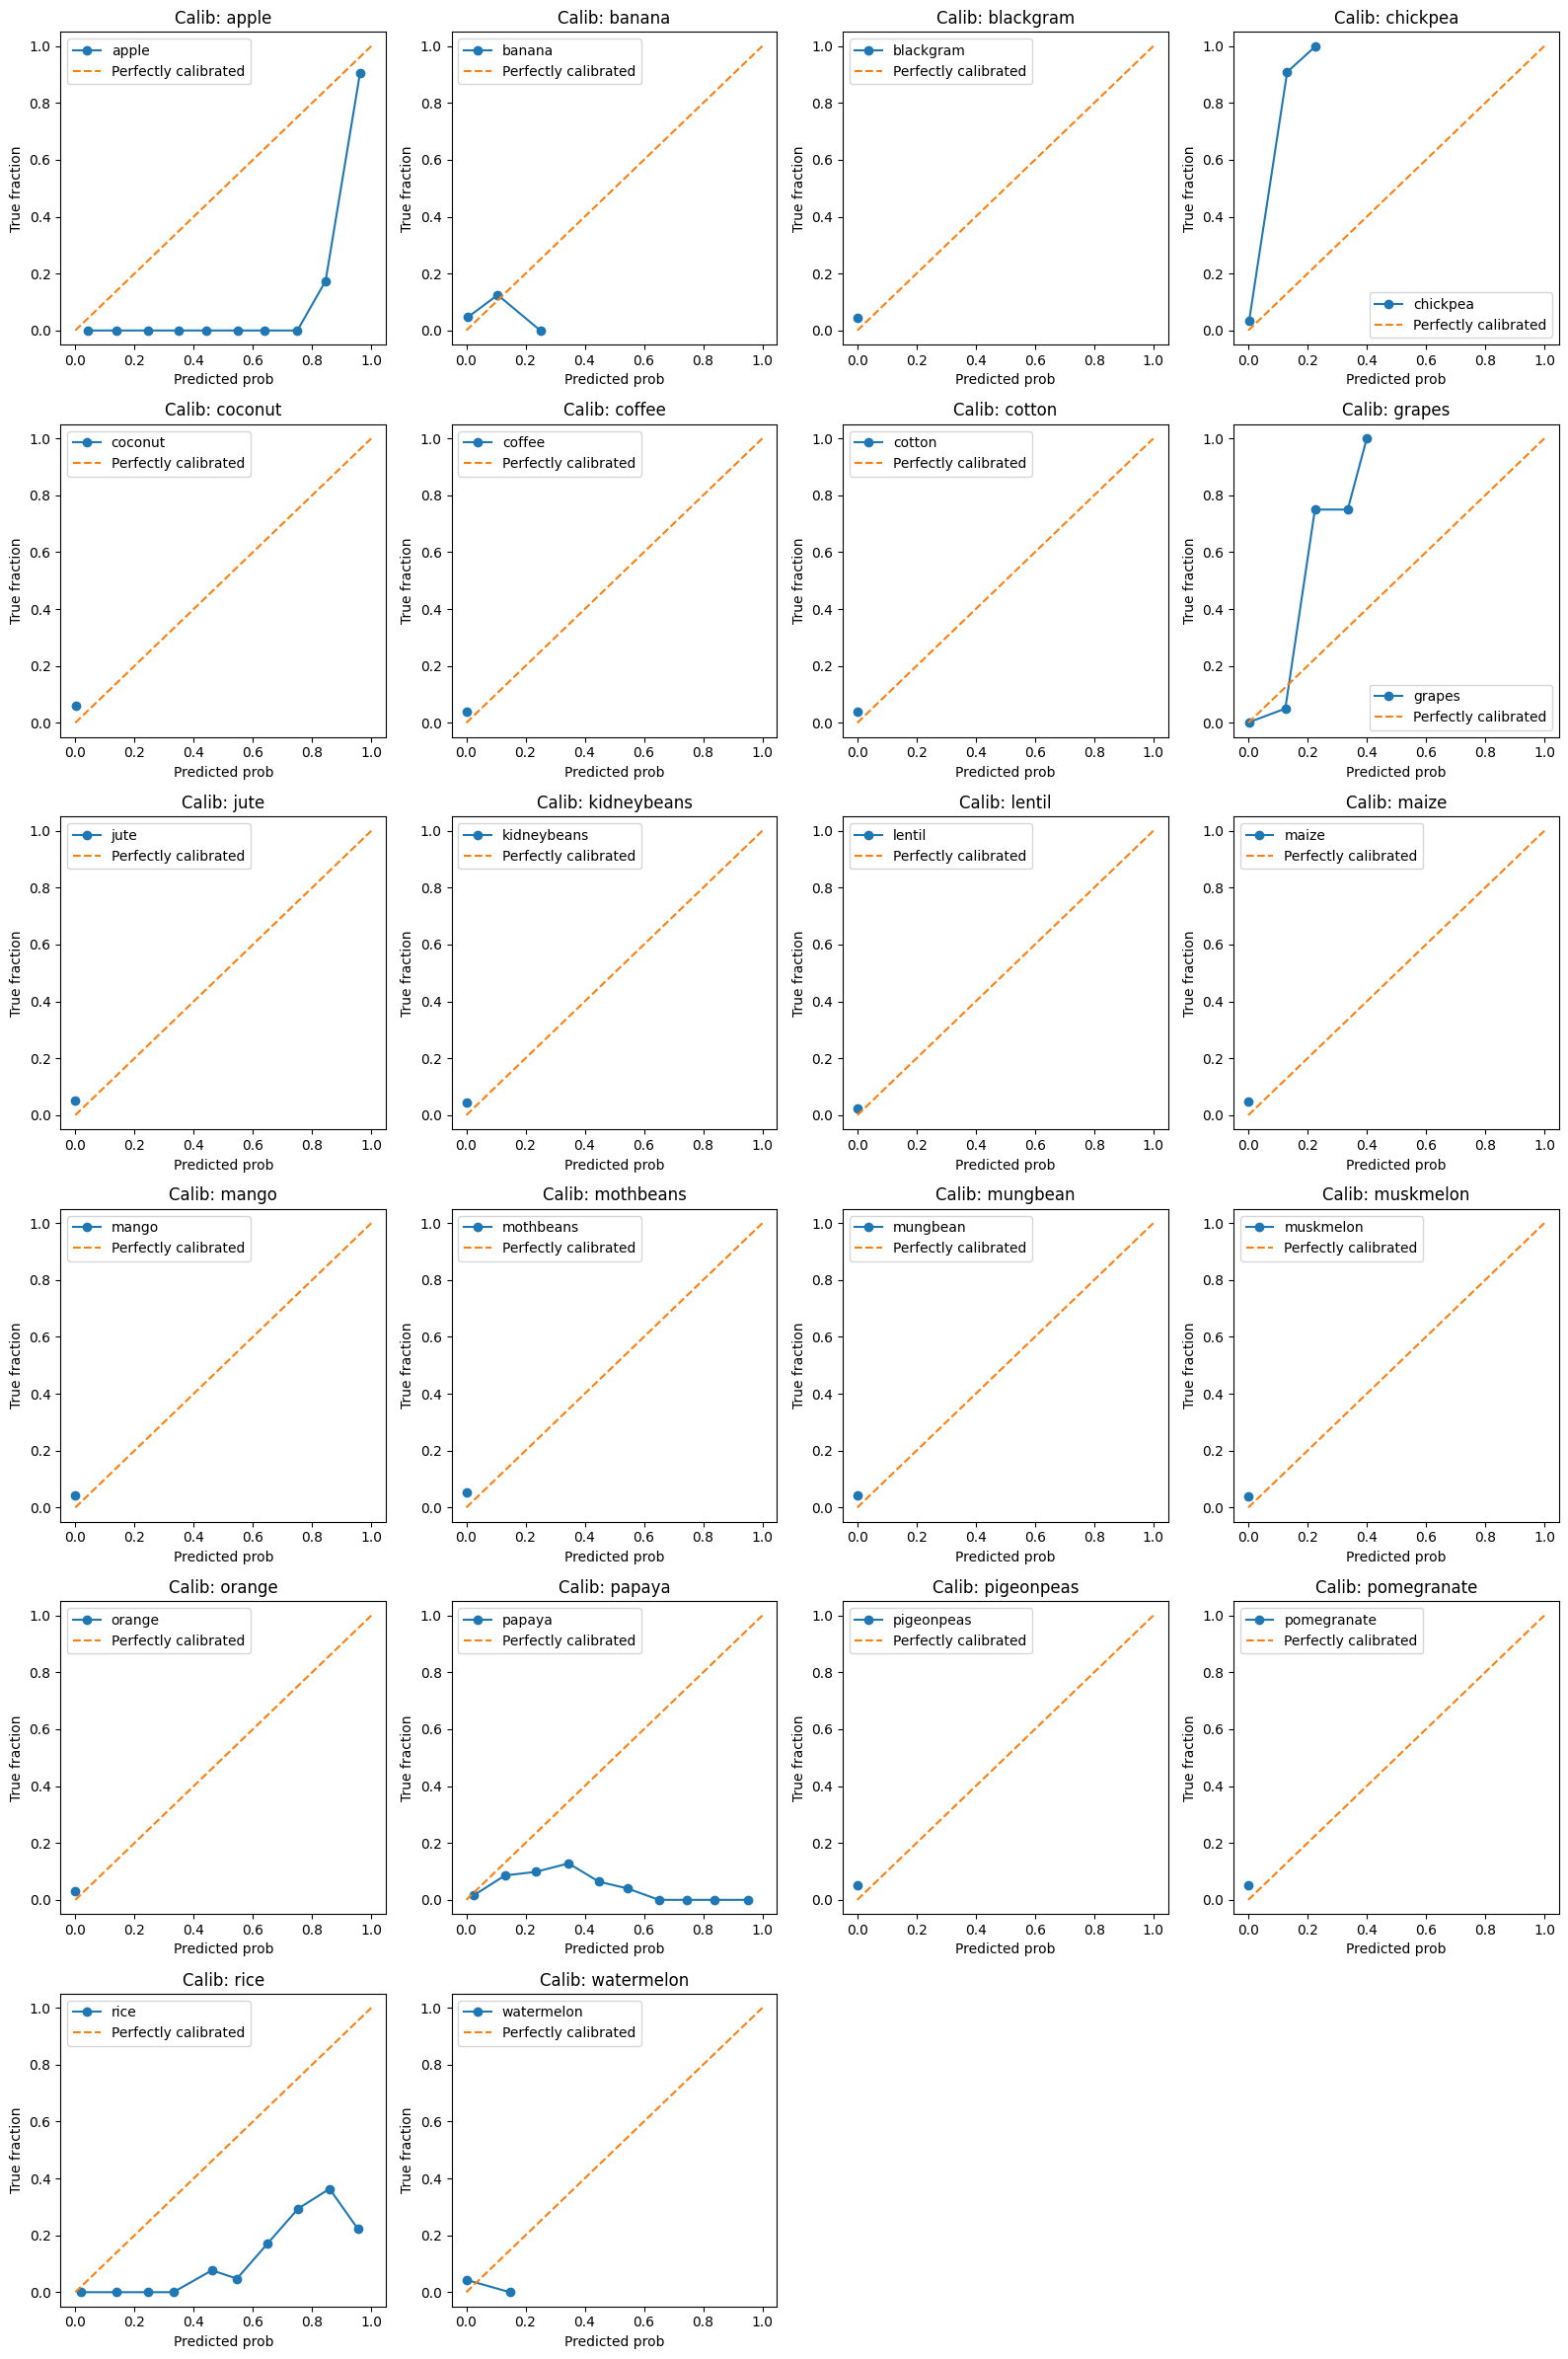

In [17]:
# Cell 3: Plot a grid of calibration curves
n_classes = len(class_names)
ncols = 4
nrows = int(np.ceil(n_classes / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    # true-vs-pred for class i
    y_true_bin = (y_test == i).astype(int)
    y_prob_bin = probs[:, i]
    prob_true, prob_pred = calibration_curve(
        y_true_bin, y_prob_bin,
        n_bins=10, strategy='uniform'
    )
    ax = axes[i]
    ax.plot(prob_pred, prob_true, marker='o', label=f'{cls}')
    ax.plot([0,1], [0,1], '--', label='Perfectly calibrated')
    ax.set_title(f'Calib: {cls}')
    ax.set_xlabel('Predicted prob')
    ax.set_ylabel('True fraction')
    ax.legend()

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
